In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import func
from sqlalchemy import create_engine

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn = engine.connect()

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [5]:
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

## Precipitation Analysis

In [7]:
prcp = session.query(Measurement).first()
prcp.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e2fc227e80>,
 'date': datetime.date(2010, 1, 1),
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
current = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = current[0].replace(year = (current[0].year - 1))
year_ago = year_ago.strftime("%Y-%m-%d")
year_ago

'2016-08-23'

In [28]:
year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago)
year_prcp = pd.read_sql_query(year.statement, engine, index_col='date')
year_prcp = year_prcp.rename(columns={'prcp':'Precipatation'})
year_prcp.head()

,Precipatation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


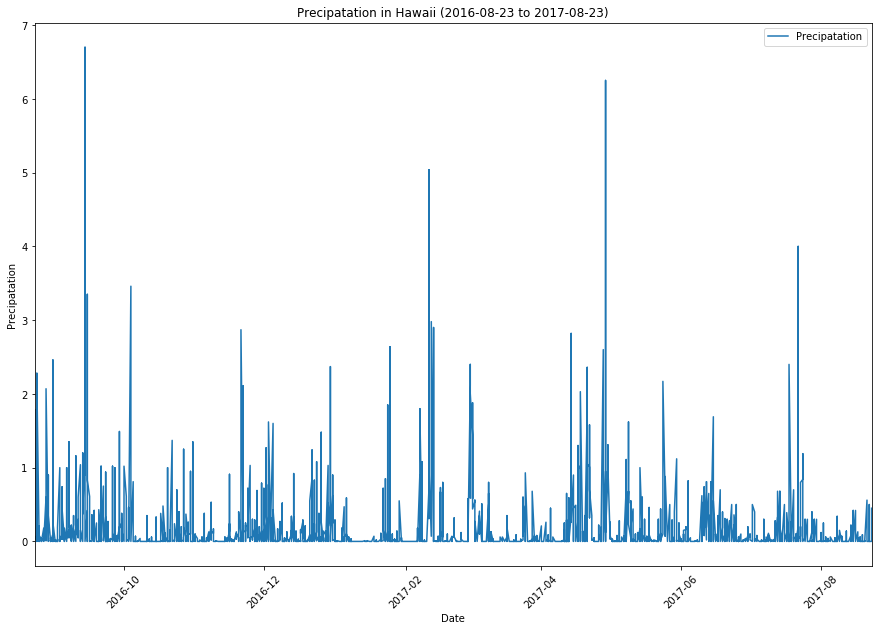

In [33]:
year_prcp.plot(figsize = (15,10), use_index=True, rot = 45, legend=True)
plt.title("Precipatation in Hawaii ({} to {})".format(year_prcp.index.min(),year_prcp.index.max()))
plt.ylabel('Precipatation')
plt.xlabel('Date')
plt.legend
plt.show()

## Station Analysis

In [41]:
s_count = session.query(Station.id).count()
s_count

9

In [55]:
tobs1 = session.query(Measurement.station, Station.name, func.count(Measurement.id))\
    .filter(Station.station == Measurement.station).group_by(Measurement.station)\
    .order_by(func.count(Measurement.tobs).desc()).all()
tobs1

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [56]:
s_active = tobs1[0]
s_active

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [62]:
tobs2 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=year_ago)\
        .filter(Measurement.station==s_active[0]).order_by(Measurement.date).all()
tobs2 = [i[1] for i in tobs2]

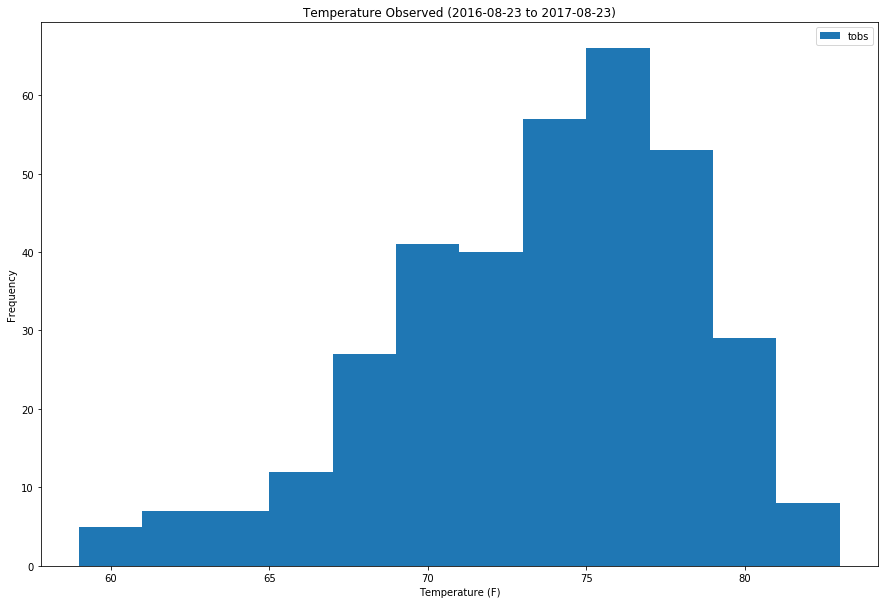

In [67]:
plt.figure(figsize=(15,10))
plt.hist(tobs2, bins=12, label='tobs')
plt.title("Temperature Observed ({} to {})".format(year_prcp.index.min(),year_prcp.index.max()))
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.show()

## Temperature Analysis

In [84]:
def calc_temps(start, end):
    return {'MIN':session.query(func.min(Measurement.tobs)).filter(Measurement.date.between(start,end)).scalar(),\
            'MAX':session.query(func.avg(Measurement.tobs)).filter(Measurement.date.between(start,end)).scalar(),\
            'AVG':session.query(func.max(Measurement.tobs)).filter(Measurement.date.between(start,end)).scalar()}
    
vacay = calc_temps('2016-01-01','2017-01-01')
vacay

{'AVG': 84.0, 'MAX': 74.1317494600432, 'MIN': 56.0}

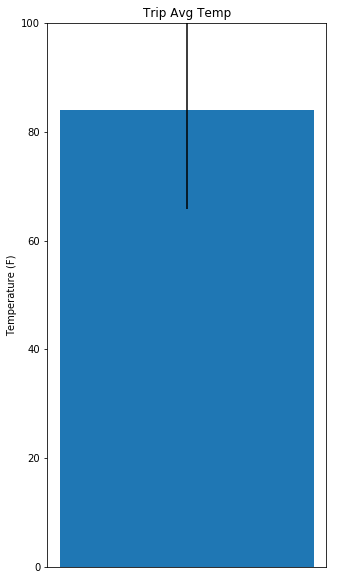

In [89]:
plt.figure(figsize=(5,10))
plt.bar(0,vacay['AVG'], yerr=(vacay['MAX']-vacay['MIN']))
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temperature (F)")
plt.show()